In [1]:
# dependencies
import os, math, time, random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
 
import cv2
from glob import glob
import tensorflow as tf
from sklearn.utils import shuffle

 # skimage
from skimage.io import imread 
from skimage import io
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage import data, color

# pil
from PIL import Image as pil_image

import warnings
warnings.filterwarnings("ignore")

# from keras
import keras
from keras.layers import Concatenate, Input
from keras.models import Model
from keras.utils import np_utils
from keras import optimizers
from keras.models import Sequential
from keras.layers import  MaxPooling2D, BatchNormalization, Flatten
from keras.layers import Input, Conv2D, Activation,  MaxPool2D, AveragePooling2D
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, GlobalMaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping

from keras.activations import relu, sigmoid
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.nasnet import NASNetMobile
from keras.applications.vgg16 import VGG16
from keras.layers import Concatenate
from keras.models import Model
from keras.optimizers import Adam
#from keras.applications.resnet import ResNet101

# scikit learn helper functions
from sklearn.model_selection import train_test_split

In [2]:
IMG_SIZE = 32 # in the given original size

In [3]:
print('Given files: ', os.listdir('../'))
# data shapes
print('train images: ', len(os.listdir('train/train')))
print('test images: ', len(os.listdir('test/test')))

# folders
train_folder = 'train/train'
test_folder = 'test/test'
train_df = pd.read_csv('train.csv')

Given files:  ['.ipynb_checkpoints', 'finalderin', 'finalyapayzeka', 'Untitled.ipynb']
train images:  17500
test images:  4000


In [4]:
train_images_path = glob('train/train/*.jpg')
test_images_path = glob('test/test/*.jpg')

In [5]:
# retunrs a complete path to a image with Image name
def expand_path(path):
    if os.path.isfile('train/train/' + path):
        return 'train/train/' + path
    if os.path.isfile('test/test/' + path):
        return 'test/test/' + path
    return path

# returns a resized black and white PIL Image object
def pil_image_load(image):
    image_path = expand_path(image)
    image = pil_image.open(image_path)#.convert('L')
    return image.resize((IMG_SIZE, IMG_SIZE))
    #return image
    
# load the resized image
def read_image(img_path, resized_shape=None):
    # expanding img_path to complete image path
    img_path = expand_path(img_path)
    image = imread(img_path)
    gray_image = color.rgb2gray(image)
    rgb_image = color.gray2rgb(gray_image)
    if resized_shape:
        image_resized = resize(rgb_image,(resized_shape,resized_shape, 3))
        return image_resized[:,:]/255
    return rgb_image[:,:]/255

In [60]:
# train data dataframe
train_df['image'] = train_df['id'].apply(lambda path: read_image(path))

# creating test dataframe
test_df = pd.DataFrame(columns=["id", "image"])
test_df['id'] = os.listdir('test/test/')
test_df['image'] = test_df['id'].apply(lambda path: read_image(path))

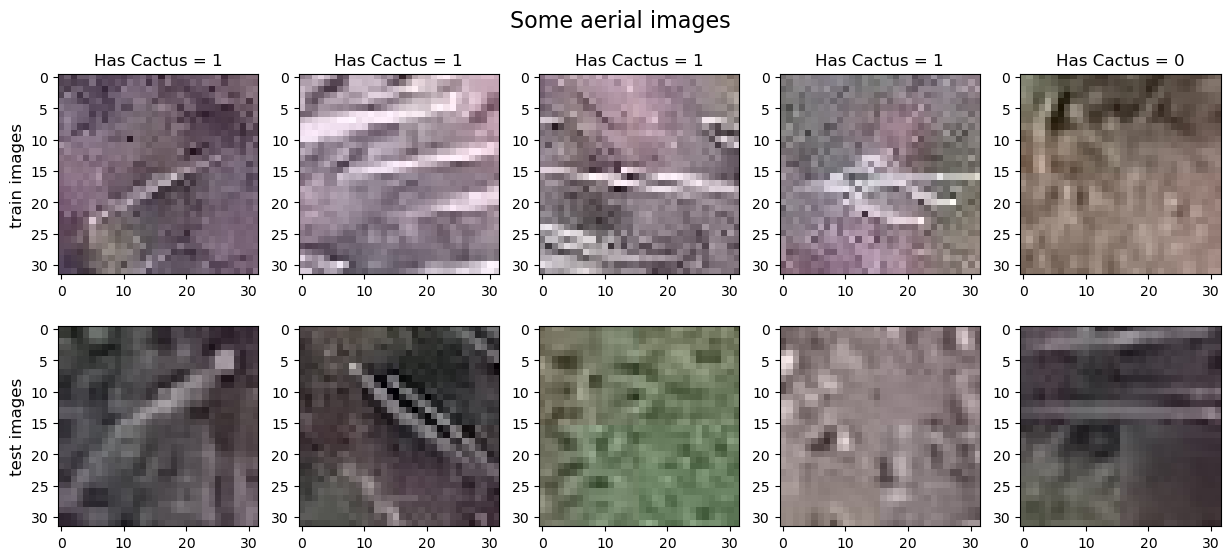

In [7]:
# some visualizations 
random.shuffle(train_images_path)
fig, ax = plt.subplots(2,5, figsize=(15,6))
fig.suptitle('Some aerial images',fontsize=16)

df = shuffle(train_df)
for i, item in enumerate(df.values[15:20]):
    image = pil_image.open(expand_path(item[0]))
    ax[0,i].imshow(image)
    ax[0, i].set_title('Has Cactus = %d' % (item[1]))
ax[0,0].set_ylabel('train images', size='large')

for i, path in enumerate(test_images_path[:5]):
    image = pil_image.open(path)
    #image = image.resize((IMG_SIZE, IMG_SIZE))
    ax[1,i].imshow(image)
ax[1,0].set_ylabel('test images', size='large');

In [8]:
# returns a batch of image for training
def train_batch(train_df):
    batch_size = train_df.shape[0]
    images = train_df.image.values
    first_image = images[0]
    x_train = []
    y_train = train_df.has_cactus.values
    for i, image in enumerate(images):
        x_train.append(image.tolist())
    x_train = np.array(x_train)
    y_train = y_train.reshape(len(y_train), 1)
    return x_train, y_train

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Dropout

class CustomCNN(tf.keras.Sequential):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = Conv2D(128, (3, 3), strides=(1, 1), input_shape=(IMG_SIZE, IMG_SIZE, 3))
        self.batchnorm1 = BatchNormalization()
        self.act1 = Activation('relu')
        self.pool1 = MaxPooling2D((2, 2))

        self.conv2 = Conv2D(256, (3, 3), strides=(1, 1))
        self.batchnorm2 = BatchNormalization()
        self.act2 = Activation('relu')
        self.pool2 = MaxPooling2D((2, 2))

        self.conv3 = Conv2D(128, (3, 3), strides=(1, 1))
        self.batchnorm3 = BatchNormalization()
        self.act3 = Activation('relu')
        self.pool3 = MaxPooling2D((2, 2))

        self.flatten = Flatten()
        self.dense1 = Dense(512, activation='relu')
        self.dropout1 = Dropout(0.5)
        self.dense2 = Dense(256, activation='relu')
        self.dropout2 = Dropout(0.25)
        self.dense3 = Dense(1, activation='sigmoid')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.batchnorm1(x)
        x = self.act1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.act2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = self.act3(x)
        x = self.pool3(x)

        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dropout1(x)
        x = self.dense2(x)
        x = self.dropout2(x)
        x = self.dense3(x)

        return x
    def build(self,input_shape):
        self.built=True




In [10]:
# CNN model
def CNN():
    model = Sequential()
    model.add(Conv2D(128, (3, 3), strides = (1, 1), input_shape = (IMG_SIZE, IMG_SIZE, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(256, (3, 3), strides = (1,1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), strides = (1,1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    
    # fully connected layer
    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.25))
    
    # output
    model.add(Dense(1, activation='sigmoid'))
    
    # compiling
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [11]:
# Ref: https://www.kaggle.com/CVxTz/cnn-starter-nasnet-mobile-0-9709-lb
def NASNetMoibleClassifier():
    inputs = Input((IMG_SIZE, IMG_SIZE, 3))
    base_model = NASNetMobile(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))#, weights=None
    x = base_model(inputs)
    
    out1 = GlobalMaxPooling2D()(x)
    out2 = GlobalAveragePooling2D()(x)
    out3 = Flatten()(x)
    
    out = Concatenate(axis=-1)([out1, out2, out3])
    out = Dropout(0.5)(out)
    out = Dense(1, activation="softmax")(out)
    
    model = Model(inputs, out)
    model.compile(optimizer=Adam(0.0001), loss='binary_crossentropy', metrics=['acc'])
    model.summary()
    return model

In [12]:
# Ref: https://www.kaggle.com/CVxTz/cnn-starter-nasnet-mobile-0-9709-lb
def VGGModel():
    model_vg = VGG16(weights='imagenet',include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    #model_vg.trainable = False
    
    model = Sequential()
    model.add(model_vg)
    model.add(Flatten())
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    model.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [13]:
#model = CNN()
#model.summary()

In [14]:
# training data
X_train, y_train = train_batch(train_df)
print(len(X_train))
print(len(y_train))

17500
17500


In [15]:
 # batch train (with batch load) the model with training data
def train_model(model, X_train, y_train,pngName,accuracyName='accuracy', epochs=5, verbose=None):
    begin = time.time()
    # checkpoint
    checkpointer = ModelCheckpoint(filepath='weights.hdf5', monitor='val_'+accuracyName, verbose=0, save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_accuracy', verbose=1, patience=5)
    modelHistory=[]
    modelLoss=[]
    modelAcc=[]
    modelValAcc=[]
    modelValLoss=[]
    for i in range(1, epochs + 1):
        #print('************************************')
        #print('Epoch: ', i, '/', epochs)
        #print('************************************')
        if verbose:
            verbose = verbose
        # fitting
        model.fit(X_train, y_train, verbose=verbose, callbacks=[checkpointer, early_stopping], validation_split=0.1, shuffle=True)
        print(model.history.history)
        modelLoss.append(model.history.history['loss'])
        modelAcc.append(model.history.history[accuracyName])
        modelValAcc.append(model.history.history['val_'+accuracyName])
        modelValLoss.append(model.history.history['val_loss'])

        
        # plot the loss values


    # done!
    plt.plot(modelAcc)
    plt.plot(modelValAcc)
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig(pngName+'valacc.png', dpi=300, bbox_inches='tight')
    plt.show()
    # plot the accuracy values
    plt.plot(modelAcc)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy values')
    plt.legend()
    plt.savefig(pngName+'accuracy.png', dpi=300, bbox_inches='tight')
    plt.show()

    # plot the accuracy values
    plt.plot(modelLoss)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss values')
    plt.legend()
    plt.savefig(pngName+'loss.png', dpi=300, bbox_inches='tight')
    plt.show()
    # plot the Vall Losss values
    plt.plot(modelAcc)
    plt.plot(modelValLoss)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig(pngName+'valloss.png', dpi=300, bbox_inches='tight')
    plt.show()
    #accuracyYazdir(accuracy_score(Y_test, predicted.round()),"selectedModelText"+"_accuracy"+ str(index))
    print("CNN/")
    print(conf)
    #  confMatrix(cf_matrix=conf,pngName="CNN/"+"_karisiklik_matris"+str(index))
    
    
    
    elapsed = time.time() - begin
    print('total training time: ', elapsed)
    return model



In [16]:

def accuracyYazdir(acc,pngName):

  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(acc, acc, 'bo', label='Accuracy')
  plt.title('Accuracy')
  plt.xlabel('Accuracy')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.savefig(pngName+'.png', dpi=300, bbox_inches='tight')
  plt.show()

def confMatrix(cf_matrix,pngName):
  from sklearn.metrics import confusion_matrix
  import sklearn.metrics as mt
  group_names = ['True Neg','False Pos','False Neg','True Pos']
  group_counts = ["{0:0.0f}".format(value) for value in
                  cf_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in
                      cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
  ax.set_title('Seaborn Confusion Matrix with labels\n\n');
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ');
  ## Ticket labels - List must be in alphabetical order
  ax.xaxis.set_ticklabels(['False','True'])
  ax.yaxis.set_ticklabels(['False','True'])
  plt.legend()
  ## Display the visualization of the Confusion Matrix.
  plt.savefig(pngName+'.png', dpi=300, bbox_inches='tight')
  plt.show()

In [17]:

def benimModel():
    model = CustomCNN()
    model.build(input_shape=(IMG_SIZE, IMG_SIZE, 3))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [18]:
epoch_sz=2
fileName=""
model=CNN()
batch_sz=64
selected_cb=1
if (selected_cb==1):
    fileName=""
if (selected_cb==2):
    fileName=""
if (selected_cb==3):
    fileName=""
if (selected_cb==4):
    fileName=""

In [160]:
# training
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
kf = KFold(n_splits=2)
x=X_train
y=y_train
accuracies = []
confs = []
accs = []
index=1

for train_index, test_index in kf.split(x):
        x_train, x_test = x[train_index], x[test_index]
        Y_train, Y_test = y[train_index], y[test_index]
        
        if (selected_cb==1):
            model=CNN()
            model.summary()
            md1 = train_model(model, x_train, Y_train,'CNN/', epochs=3, verbose=1)
           #  create lists for the loss and accuracy values        
            predicted = md1.predict(x_test)
            conf = confusion_matrix(Y_test, predicted)
            confMatrix(cf_matrix=conf,pngName="CNN/"+"_karisiklik_matris"+str(index))
            md1.save('CNN/model.h5')
            v
        if (selected_cb==2):
            model=VGGModel()
            model.summary()
            md1 = train_model(model, x_train, Y_train,'VGGModel/', epochs=3, verbose=1)
            predicted = md1.predict(x_test).astype("int")
            conf = confusion_matrix(Y_test, predicted)
            confMatrix(cf_matrix=conf,pngName="VGGModel/"+"_karisiklik_matris"+str(index))
            md1.save('VGGModel/model.h5') 
            
        if (selected_cb==3):        
            model=NASNetMoibleClassifier()
            model.summary()
            md1 = train_model(model, x_train, Y_train,'NASNetMoibleClassifier/','acc', epochs=3, verbose=1)
            predicted = md1.predict(x_test).astype("int")
            conf = confusion_matrix(Y_test, predicted)
            confMatrix(cf_matrix=conf,pngName="NASNetMoibleClassifier/"+"_karisiklik_matris"+str(index))
            md1.save('NASNetMoibleClassifier/model.h5')

        if (selected_cb==4):
            model=benimModel()
            model.summary()
            md1 = train_model(model, x_train, Y_train,'benim/', epochs=3, verbose=1)
            predicted = md1.predict(x_test).astype("int")
            conf = confusion_matrix(Y_test, predicted)
            confMatrix(cf_matrix=conf,pngName="benim/"+"_karisiklik_matris"+str(index))
            md1.save('benim/model.h5')
           

                
        index+=1
        

Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_159 (Conv2D)         (None, 30, 30, 128)       3584      
                                                                 
 batch_normalization_156 (Ba  (None, 30, 30, 128)      512       
 tchNormalization)                                               
                                                                 
 activation_1290 (Activation  (None, 30, 30, 128)      0         
 )                                                               
                                                                 
 max_pooling2d_157 (MaxPooli  (None, 15, 15, 128)      0         
 ng2D)                                                           
                                                                 
 conv2d_160 (Conv2D)         (None, 13, 13, 256)       295168    
                                                     

KeyboardInterrupt: 

In [71]:
# Test prediction data preparation
selected_cb=1
esik=0.5
if (selected_cb==1):
    model = tf.keras.models.load_model('CNN/model.h5')
    esik=0.165
if (selected_cb==2):
    model= tf.keras.models.load_model("VGGModel/model.h5")
    esik=0.75
if (selected_cb==3):
    model= tf.keras.models.load_model("NASNetMoibleClassifier/model.h5")
    esik=0.5
if (selected_cb==4):
    model=model.load_model("benim/model.h5")
    esik=0.5

test_images = []
for image in test_df.image.values:
    test_images.append(image)
X_test = np.array(test_images)
#prediction on test data
y_pred = model.predict(X_test)
y_test = (y_pred.flatten()>esik).astype('int8')
# submission file preparation
submission=pd.DataFrame({'id':test_df['id']})
submission['has_cactus']=y_test
#submitting the results
submission.to_csv("submission.csv",index=False)

126/126 [==============================] - 7s 58ms/step


PermissionError: [Errno 13] Permission denied: 'submission.csv'

In [70]:
print(y_pred)

[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


In [72]:
y_test = (y_pred.flatten()>0.75).astype('int8')
submission['has_cactus']=y_pred
submission.to_csv("submission.csv",index=False)

In [ ]:


from sklearn.metrics import confusion_matrix
conf = confusion_matrix(X_test, predicted)
confMatrix(cf_matrix=conf,pngName="_karisiklik_matris_test")

NameError: name 'img_path' is not defined

In [ ]:
y = [0.1, 0.7]
plt.plot( y)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
